<a href="https://colab.research.google.com/github/mohsenmolaei/seriesnet_based/blob/main/seriesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/tripple stage seriesnet"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/tripple stage seriesnet


In [2]:
import pdb
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.feature_selection import mutual_info_classif
# !pip install backtrader

# !pip install yfinance
# import yfinance as yf
!pip install lingam
import feature_selection
import TSASeriesNet
# import feature_selection
if torch.cuda.is_available():
    # dev = "TPU:0"
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 27.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pygam to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 15.7

In [23]:
data= pd.read_csv('data.csv')
data.set_index("time_stamp",inplace=True,drop=True)
# data
# label_encoder = LabelEncoder()
# n_bins = 50
# data['difficulty_latest'] = data['difficulty_latest'].astype(float)
# data['hash_rate_mean'] = data['hash_rate_mean'].astype(float)

# data['difficulty_latest'] = label_encoder.fit_transform(pd.cut(data['difficulty_latest'] , n_bins, retbins=True)[0])
# data['hash_rate_mean'] = label_encoder.fit_transform(pd.cut(data['hash_rate_mean'], n_bins, retbins=True)[0])

# whatcol=[ 'price_drawdown_relative','difficulty_latest',
#            'hash_rate_mean', 'active_more_1y_percent', 'utxo_created_value_median', 
#            'transfers_volume_median', 'utxo_spent_value_median']

# X, Y = data.drop(["price_usd_close"],axis =1), np.array(data.price_usd_close) #data[whatcol]
# X.shape

In [4]:
# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(data)

# label_encoder = LabelEncoder()
# n_bins = 50
# y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

# mi= pd.DataFrame()
# mi = mutual_info_classif(X, y_train)#, discrete_features=discrete_vars)
# mi = pd.Series(mi)

# mi.index = col
# mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")

# plt.show()

# # xindex = mi.sort_values(ascending=False)[0:8]
# # X = data[xindex.index]


In [22]:
data_top15= pd.read_csv('top15.csv')
data_top15.set_index("time_stamp",inplace=True,drop=True)

# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(data_top15)

# label_encoder = LabelEncoder()
# n_bins = 50

# mi15= pd.DataFrame()
# mi15 = mutual_info_classif(data_top15, y_train)#, discrete_features=discrete_vars)
# mi15 = pd.Series(mi15)

# mi15.index = data_top15.columns
# mi15.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")

# plt.show()

In [24]:
# ccol = ['CL=F', 'CPI', 'DXYN', 'GC=F', 'SI=F', '^DJI', '^IXIC', '^RUT', '^TNX','EURUSD=X', 'GBPUSD=X', '^FTSE', 'N225']

Condition= pd.read_csv('Condition.csv')
Condition.set_index("time_stamp",inplace=True,drop=True)
# Condition

# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(Condition)

# label_encoder = LabelEncoder()
# n_bins = 50
# y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

# mi= pd.DataFrame()
# mi = mutual_info_classif(Condition, y_train)#, discrete_features=discrete_vars)
# mi = pd.Series(mi)

# mi.index = Condition.columns
# mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")
# plt.show()

# xindex = mi.sort_values(ascending=False)[0:8]
# Condition = data[xindex.index]

# Condition.columns

In [53]:
def get_rsi(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1]  # cause the diff is 1 shorter
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
            
        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n
        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

In [59]:
col = list(data.columns)+ list(Condition.columns)+list(data_top15.columns)
cond = pd.DataFrame(np.hstack((data , Condition)))
cond = pd.DataFrame(np.hstack((cond,data_top15)))
cond.columns =col


# f_col = ["receiving_count", "^DJI"]

# import importlib
# import feature_selection
# importlib.reload(feature_selection)

crypto = "price_usd_close"
# selectmx , matrix_correlation , matrix_observed , matrix_latent , matrix_granger , matrix_mi = feature_selection.select_matrix(cond, crypto)
Y = cond.price_usd_close
# cond =cond.drop(["price_usd_close"],axis =1)


# selectmx.to_csv("select_matrix.csv")

# matrix_correlation.to_csv("matrix_correlation.csv")
# matrix_observed.to_csv("matrix_observed.csv")
# matrix_latent.to_csv("matrix_latent.csv")
# matrix_granger.to_csv("matrix_granger.csv")
# matrix_mi.to_csv("matrix_mi.csv")


# داده های تست روزهای اخیر
# test_data= pd.read_csv('test_data.csv')
# xtest = test_data.price_usd_close
# condtest = test_data[["receiving_count", "^DJI"]]
# ytest = test_data.price_usd_close

# داده های تست جدا شده از 143 روز اخر آموزش
test_df = cond.iloc[-243:]
cond = cond.iloc[:-243]
Y = cond.price_usd_close
cond = cond.drop("price_usd_close",axis=1)
X = get_rsi(cond["BTC-USD"], n=7)

xtest.shape = get_rsi(test_df["BTC-USD"], n=7) 
condtest = test_df.drop("price_usd_close",axis=1)
condtest =condtest#[f_col]
ytest = test_df.price_usd_close


(243, 59)

In [8]:
# start = "2006-01-01"
# end="2023-3-28"
# indnas = ["^IXIC", "AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "NVDA", "PYPL", "ADBE", "NFLX", "INTC", "CSCO", "CMCSA", "AMD", "PEP", "CHTR", "TMUS", "AVGO", "GILD", "AMGN", "QCOM", "JD", "TXN", "BIIB", "VRTX", "REGN", "ISRG", "MRNA", "COST", "BKNG", "ADP"]
# try : 
#     data_top_index = yf.download(indnas ,start=start, end=end , interval ="1d") #1137
# except Exception as e: 
#     print("error")
# data_top_index.set_index(pd.to_datetime(data_top_index.index).date,inplace=True) 
# data_top_index = data_top_index.Close.fillna(method='ffill') 

# try:
#     data_crypto = yf.download("BTC-USD" ,start=start, end=end , interval ="1d")
# except Exception as e: 
#     print("error")
# data_crypto.set_index(pd.to_datetime(data_crypto.index).date,inplace=True) 

# merged_df = pd.merge(data_crypto.Close, data_top_index , left_index=True, right_index=True, how='outer')
# merged_df.fillna(method='bfill', inplace=True) 

# merged_df = merged_df.rename_axis('time_stamp')

# merged_df.to_csv("nasdaq.csv")

In [9]:
# start = "2023-04-01"
# end="2023-5-09"
data_top_index= pd.read_csv('nasdaq.csv')
data_top_index.set_index("time_stamp",inplace=True,drop=True)
# data_top_index = data_top_index[['^IXIC','AAPL','GOOGL','AMZN', 'MRVL', 'MSFT',]]
Y = data_top_index["^IXIC"]
# data_top_index = data_top_index.drop("^IXIC",axis =1)

autoscaler = StandardScaler()
features = autoscaler.fit_transform(data_top_index)

# label_encoder = LabelEncoder()
# n_bins = 50
# y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

# mi= pd.DataFrame()
# mi = mutual_info_classif(data_top_index, y_train)#, discrete_features=discrete_vars)
# mi = pd.Series(mi)

# mi.index = data_top_index.columns
# mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
# plt.ylabel('Mutual Information')
# plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")
# plt.show()
test_df = data_top_index.iloc[-430:]
cond = data_top_index.iloc[:-430]
Y = cond["^IXIC"]
cond = cond.drop("^IXIC",axis=1)

xtest = test_df["^IXIC"]
condtest = test_df.drop("^IXIC",axis=1)
ytest = test_df["^IXIC"]

f_col = col= condtest.columns.values
X = cond


**TEST data**

In [46]:
"""# scale features""" 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
MMScaler = MinMaxScaler()
SScaler = StandardScaler()
condscaler = StandardScaler()

MMScaler_test = MinMaxScaler()
SScaler_test = StandardScaler()
condscaler_test = StandardScaler()

# train and validation data scaler
X_trans = SScaler.fit_transform(pd.DataFrame(np.array(Y).reshape(-1, 1)))#Y.reshape(-1, 1))
condtemp = cond
c_trans = condscaler.fit_transform(condtemp)#[f_col])

# for i in range(0,len(selectmx.T)):
#   col2 = c_trans[:,i].copy()
#   if selectmx.T["price_usd_close"][i] >= max(selectmx.T["price_usd_close"])  -1:
#     print(col[i])
#     col2 *= selectmx.T["price_usd_close"][i]/max(selectmx.T["price_usd_close"])
#   else:
#     col2 *= 0
#   c_trans[:, i] = col2
# print("\n\n")

# for i in range(0,len(result_df.T)):
#   col2 = c_trans[:,i].copy()
#   if result_df.squeeze().tolist()[i] >= 1:
#     print(col[i])
#     col2 *= result_df.T[i]
#   else:
#     col2 *= 0
#   c_trans[:, i] = col2
# print("\n\n")

# c_trans = pd.DataFrame(c_trans)
# c_trans = c_trans.drop(c_trans.columns[c_trans.apply(lambda col: col2.all() == 0)], axis=1)


# for i in range(0,len(selectmx.T)):
#   col2 = c_trans[:,i].copy()
#   if selectmx.T["Close"][i] >= max(selectmx.T["Close"]) -4:
#     print(col[i])
#     col2 *= selectmx.T["Close"][i]/max(selectmx.T["Close"])
#   else:
#     col2 *= 0
#   c_trans[:, i] = col2
# print("\n\n")
# c_trans = pd.DataFrame(c_trans)
# c_trans = c_trans.drop(c_trans.columns[c_trans.apply(lambda col: col.all() == 0)], axis=1)


y_trans = MMScaler.fit_transform(pd.DataFrame(np.array(X).reshape(-1, 1)))
print(X_trans.shape)
print(c_trans.shape)
print(y_trans.shape)

# Test data Scaler
X_trans_test = SScaler_test.fit_transform(xtest.values.reshape(-1, 1))
c_trans_test = condscaler_test.fit_transform(condtest)
y_trans_test = MMScaler_test.fit_transform(ytest.values.reshape(-1, 1))

"""# split a multivariate sequence past, future samples (X and y)"""
def split_sequences(input_sequences, condition_seq, output_sequence, n_steps_in, n_steps_out):
    X, C, y = list(),list(), list() 
    for i in range(len(input_sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out 
        if out_end_ix >= len(input_sequences): break
        seq_x, seq_c, seq_y = input_sequences[i:end_ix], condition_seq[i:end_ix], output_sequence[end_ix:out_end_ix]
        X.append(seq_x), C.append(seq_c) ,y.append(seq_y)
    return np.array(X), np.array(C), np.array(y)


x_shape = 30
y_shape = 7
# Train data
X_ss, C_ss, y_mm = split_sequences(X_trans, c_trans, y_trans, x_shape, y_shape)
print(X_ss.shape, C_ss.shape, y_mm.shape)

#Test data
DataX_test, DataC_test, Datay_test = split_sequences(X_trans_test, c_trans_test, y_trans_test, x_shape, y_shape)

total_samples = len(cond)
train_test_cutoff = round(0.85 * total_samples)

X_train = X_ss[:-(total_samples-train_test_cutoff)]
C_train = C_ss[:-(total_samples-train_test_cutoff)]
X_test = X_ss[-(total_samples-train_test_cutoff):]
C_test = C_ss[-(total_samples-train_test_cutoff):]

y_train = y_mm[:-(total_samples-train_test_cutoff)]
y_test = y_mm[-(total_samples-train_test_cutoff):] 

# Randomly shuffle the indices
indices = np.arange(len(X_train))
np.random.shuffle(indices)

# Reorder the data using the shuffled indices
X_train = X_train[indices]
C_train = C_train[indices]
y_train = y_train[indices]


print(total_samples - train_test_cutoff)
print("Training Shape:", X_train.shape, y_train.shape)
print("Validatin Shape:", X_test.shape, y_test.shape)

"""# convert to pytorch tensors"""
X_train_tensors = Variable(torch.Tensor(X_train).to(device))
X_test_tensors = Variable(torch.Tensor(X_test).to(device))

C_train_tensors = Variable(torch.Tensor(C_train).to(device))
C_test_tensors = Variable(torch.Tensor(C_test).to(device))

y_train_tensors = Variable(torch.Tensor(y_train).to(device))
y_test_tensors = Variable(torch.Tensor(y_test).to(device))

print(X_train_tensors.shape)
print(C_train_tensors.shape)

# DataX_test, DataC_test, Datay_test
DataX_test = Variable(torch.Tensor(DataX_test).to(device))
DataC_test = Variable(torch.Tensor(DataC_test).to(device))
Datay_test = Variable(torch.Tensor(Datay_test).to(device))

"""# reshaping to rows, timestamps, features"""

X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], x_shape, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], x_shape, 
                                      X_test_tensors.shape[2])) 

C_train_tensors_final = torch.reshape(C_train_tensors,   
                                      (C_train_tensors.shape[0], x_shape, 
                                       C_train_tensors.shape[2]))
C_test_tensors_final = torch.reshape(C_test_tensors,  
                                     (C_test_tensors.shape[0], x_shape, 
                                      C_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, C_train_tensors_final.shape, y_train_tensors.shape)
print("Validation Shape:", X_test_tensors_final.shape, C_test_tensors_final.shape, y_test_tensors.shape)
print("Test Shape:", DataX_test.shape, DataC_test.shape, Datay_test.shape)


(2400, 1)
(2400, 59)
(2400, 1)
(2363, 30, 1) (2363, 30, 59) (2363, 7, 1)
360
Training Shape: (2003, 30, 1) (2003, 7, 1)
Validatin Shape: (360, 30, 1) (360, 7, 1)
torch.Size([2003, 30, 1])
torch.Size([2003, 30, 59])
Training Shape: torch.Size([2003, 30, 1]) torch.Size([2003, 30, 59]) torch.Size([2003, 7, 1])
Validation Shape: torch.Size([360, 30, 1]) torch.Size([360, 30, 59]) torch.Size([360, 7, 1])
Test Shape: torch.Size([206, 30, 1]) torch.Size([206, 30, 59]) torch.Size([206, 7, 1])


In [47]:
# %%
def NRMSELoss(yhat,y): #NRMSE
  y = y.reshape(y.shape[0], y.shape[1])
  return (torch.sqrt(torch.mean(torch.square(yhat-y))))/ (torch.max(y) - torch.min(y))

# Root Mean Squared Percentage Error (RMSPE)
def rmspe(y_pred,y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

def MAPELoss(yhat,y):
  y = y.reshape(y.shape[0], y.shape[1])
  return torch.mean(torch.abs(yhat-y)/torch.abs(y))

def SMAPELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = 2 * torch.mean(torch.abs(y_true - y_pred) / (torch.max(y_true) + torch.max(y_true)))
  return loss

def MSELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = torch.mean((y_pred - y_true)**2)
  return loss

def RMSELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = torch.sqrt(torch.mean((y_pred - y_true)**2))
  return loss
  

In [48]:
# !pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs')


def exp_lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=200):
    lr = init_lr * (0.9**(epoch // lr_decay_epoch))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def training_loop(n_epochs,learning_rate, lr_decay_epoch, network, optimiser, loss_fn, X_train, Condition_train, y_train,X_test, Condition_test, y_test):
    loss_valid_show,loss_train_show = [],[]

    if torch.cuda.is_available():
        network.cuda()
    best_valid_loss = float('inf')
    best_epoch = -1
    
    for epoch in range(n_epochs):
        # if (epoch % (lr_decay_epoch) == 0) and (epoch != 0):
        #     optimiser = exp_lr_scheduler(optimiser,epoch, init_lr= learning_rate , lr_decay_epoch= lr_decay_epoch)

        network.train()
        outputs = network.forward(X_train, Condition_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        
        # pdb.set_trace()
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        # print(optimiser.lr)

        optimiser.step() # improve from loss, i.e backprop
        # test loss
        network.eval()
        test_preds = network(X_test, Condition_test)
        test_loss = loss_fn(test_preds, y_test)

        loss_valid_show.append(test_loss.item())
        loss_train_show.append(loss.item())

        # writer.add_scalar('Accuracy/train', acc, epoch)
        writer.add_scalar('Loss/Validation', test_loss.item(), epoch)
        writer.add_scalar('Loss/Train', loss.item(), epoch)

        # Save model weights if validation loss improves
        if test_loss < best_valid_loss:
            best_valid_loss = test_loss
            best_epoch = epoch
            torch.save({'epoch': epoch, 'state_dict': network.state_dict()}, f'./weights/model_epoch_{epoch}.pth')


        if (epoch) % (20) == 0:
            print("Epoch: %4d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(),test_loss.item()))
    writer.close()
    return loss_train_show , loss_valid_show , best_valid_loss , best_epoch


In [ ]:
"""# Training"""

import torch
import gc
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

gc.collect()

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

gc.collect()

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

gc.collect()

124

In [49]:
# torch.manual_seed(17)
# torch.cuda.manual_seed(17)
# np.random.seed(17)
# torch.backends.cudnn.deterministic=True

import importlib
import Decoder_DARLM
import Encoder_DARLM
import ts_lstm
import ts_gru
import HSAM
import CBAM

importlib.reload(CBAM)
importlib.reload(Decoder_DARLM)
importlib.reload(TSASeriesNet)
importlib.reload(Encoder_DARLM)
importlib.reload(ts_lstm)
importlib.reload(ts_gru)
importlib.reload(HSAM)

n_epochs = 301
num_inputs = X_train_tensors_final.shape[1] 
dilation_c = 2
kernel_size_EN = 3
kernel_size_DE = 3
hidden_size_lstm =20

num_levels_en = 5
num_levels_de = 5
num_layers_lstm = 3
num_layers_gru = 3
features = X_train_tensors_final.shape[2]   
features_c = C_train_tensors_final.shape[2] 
output_num = y_train_tensors.shape[1]

lr_decay_epoch = 49
learning_rate = 0.001
weight_decay = 0.001

loss_fn = NRMSELoss #SMAPELoss #MAPELoss #NRMSELoss #rmspe #RMSELoss
# ANN model 
myModel = TSASeriesNet.ANNmodel(num_inputs, features_c, features, output_num, num_levels_en,num_levels_de, kernel_size_EN, kernel_size_DE, dilation_c, hidden_size_lstm, num_layers_lstm, num_layers_gru ).to(device)
optimiser = torch.optim.Adam(myModel.parameters(),weight_decay=weight_decay)#, lr=learning_rate)#, eps=1e-08)#

loss_train_show ,loss_valid_show , best_valid_loss , best_epoch= training_loop(n_epochs=n_epochs,
                                  learning_rate = learning_rate,
                                  lr_decay_epoch = lr_decay_epoch,
                                  network=myModel,
                                  optimiser=optimiser,
                                  loss_fn=loss_fn,
                                  X_train=X_train_tensors_final,
                                  Condition_train = C_train_tensors_final,
                                  y_train=y_train_tensors,
                                  X_test=X_test_tensors_final,
                                  Condition_test  = C_test_tensors_final,
                                  y_test=y_test_tensors)

print(f"best validation loss: {best_valid_loss} in epoch {best_epoch}")


Epoch:    0, train loss: 0.12580, test loss: 0.54393
Epoch:   20, train loss: 0.06534, test loss: 0.25409
Epoch:   40, train loss: 0.06028, test loss: 0.24684
Epoch:   60, train loss: 0.03468, test loss: 0.14383
Epoch:   80, train loss: 0.02900, test loss: 0.13454
Epoch:  100, train loss: 0.02719, test loss: 0.14104
Epoch:  120, train loss: 0.02640, test loss: 0.24149
Epoch:  140, train loss: 0.02520, test loss: 0.31354
Epoch:  160, train loss: 0.02474, test loss: 0.29370
Epoch:  180, train loss: 0.02409, test loss: 0.35141
Epoch:  200, train loss: 0.02413, test loss: 0.25403
Epoch:  220, train loss: 0.02377, test loss: 0.28096
Epoch:  240, train loss: 0.02356, test loss: 0.30013
Epoch:  260, train loss: 0.02334, test loss: 0.31407
Epoch:  280, train loss: 0.02345, test loss: 0.25537
Epoch:  300, train loss: 0.02311, test loss: 0.26707
best validation loss: 0.1338392198085785 in epoch 96


In [50]:
checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])
# Print initial weights
# print("Initial weights:")
# pd.DataFrame(myModel.en_darlm.firstConv.weight.cpu().detach().numpy())
# pd.DataFrame(myModel.en_darlm.network[0].cbam.cbam1.channel_att.fc1.weight.cpu().detach().numpy().reshape(-1, myModel.en_darlm.firstConv.weight.size(1)))

# for name, param in myModel.named_parameters():
#     if 'weight' in name:
#       if 'pointwise_conv' in name:
#         print(param.shape,name )

# myModel.de_darlm
# print(myModel.en_darlm.network[1].Depthwise.weight.shape,
# myModel.de_darlm.network[1].Depthwise.weight.shape,
# myModel.de_darlm.network[2].Depthwise.weight.shape,
# myModel.de_darlm.network[3].Depthwise.weight.shape,
# myModel.de_darlm.network[4].Depthwise.weight.shape,
# myModel.de_darlm.layer_1.Depthwise.weight.shape
# )
# for i in range(6):
#   print(pd.DataFrame(myModel.en_darlm.network[i].pointwise_conv.weight.cpu().detach().numpy().reshape(myModel.en_darlm.network[i].pointwise_conv.weight.size(0), -1)).shape)
for i in range(num_levels_en):
    weights = pd.DataFrame(myModel.en_darlm.network[i].pointwise_conv.weight.cpu().detach().numpy().reshape(myModel.en_darlm.network[i].pointwise_conv.weight.size(0), -1))
    row_means = np.mean((weights), axis=1)
    row_means_df = pd.DataFrame(row_means)
    row_means_df.index = col[1:]
    result_df =row_means_df #row_means_df.applymap(lambda x: 1 if x > row_means_df[0].mean() else 0 if x == row_means_df[0].mean() else 0)
    print(result_df)
    result_df.to_csv(f"causal/pointwise_conv_weights_mean{i}.csv")


# for i in range(num_levels_en):
#   plotweights = pd.DataFrame(myModel.en_darlm.network[i].pointwise_conv.weight.cpu().detach().numpy().reshape(myModel.en_darlm.network[i].pointwise_conv.weight.size(0), -1))

#   import matplotlib.pyplot as plt
#   import seaborn as sns
#   plt.figure(figsize=(2, 30))
#   sns.heatmap(plotweights.values[:, -1].reshape(-1, 1),
#               annot=True,
#               cmap='coolwarm',
#               center=0,
#               yticklabels=col[1:])
#   plt.title("Poit Waise Layer Weights Heatmap")
#   plt.xlabel("Features")
#   plt.ylabel("Neurons")
#   plt.show()


                                  0
price_drawdown_relative    0.002294
block_count                0.000779
block_interval_mean        0.002363
block_interval_median     -0.000280
block_size_mean            0.000251
block_size_sum             0.001498
utxo_created_count        -0.002288
utxo_spent_count           0.003381
utxo_created_value_sum    -0.003446
utxo_spent_value_sum      -0.000051
utxo_created_value_mean    0.000172
utxo_spent_value_mean     -0.001700
utxo_created_value_median  0.003098
utxo_spent_value_median   -0.002875
address_count              0.001186
sending_count             -0.001627
receiving_count           -0.000794
active_count              -0.001362
new_non_zero_count        -0.004882
volume_sum                -0.000609
volume_mean               -0.005186
volume_median             -0.000156
difficulty_latest         -0.001390
hash_rate_mean            -0.006991
active_more_1y_percent     0.001979
count                      0.003192
rate                      -0

In [51]:
checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])

test_predict = myModel(DataX_test, DataC_test)  # get the last sample
test_predict = test_predict.detach().cpu().numpy()
# test_predict = MMScaler_test.inverse_transform(test_predict)
# first_day_test_predict = test_predict[:, 0]  # get the first day of the 7-day predictions

test_target = Datay_test.detach().cpu().numpy()  # last sample again
# first_day_test_target = MMScaler_test.inverse_transform(test_target.flatten().reshape(1, -1))
# first_day_test_target = first_day_test_target[:, ::y_shape]  # get the corresponding first day in true price

def NRMSELoss_test(yhat,y): #NRMSE
  return (np.sqrt(np.mean(np.square(yhat-y))))/ (np.max(y) - np.min(y))

# NRMSELoss_res = NRMSELoss_test(test_predict[:,0] ,first_day_test_target.reshape(-1) )
NRMSELoss_res = NRMSELoss_test(test_predict ,test_target.reshape(test_target.shape[0],test_target.shape[1]) )
print(NRMSELoss_res)

# # 
# start = "2016-01-01"
# end="2023-3-28"

# try : 
#     data_top_index = yf.download("BTC-USD" ,start=start, end=end , interval ="1d") #1137
# except Exception as e: 
#     print("error")


# testCSV = pd.DataFrame(test_predict[:,0], index=data_top_index.iloc[-106:].index )
# TrueCSV = pd.DataFrame(first_day_test_target.reshape(-1),index=data_top_index.iloc[-106:].index )

# testCSV.to_csv("test_price.csv") 
# TrueCSV.to_csv("True_price.csv")


0.3419148


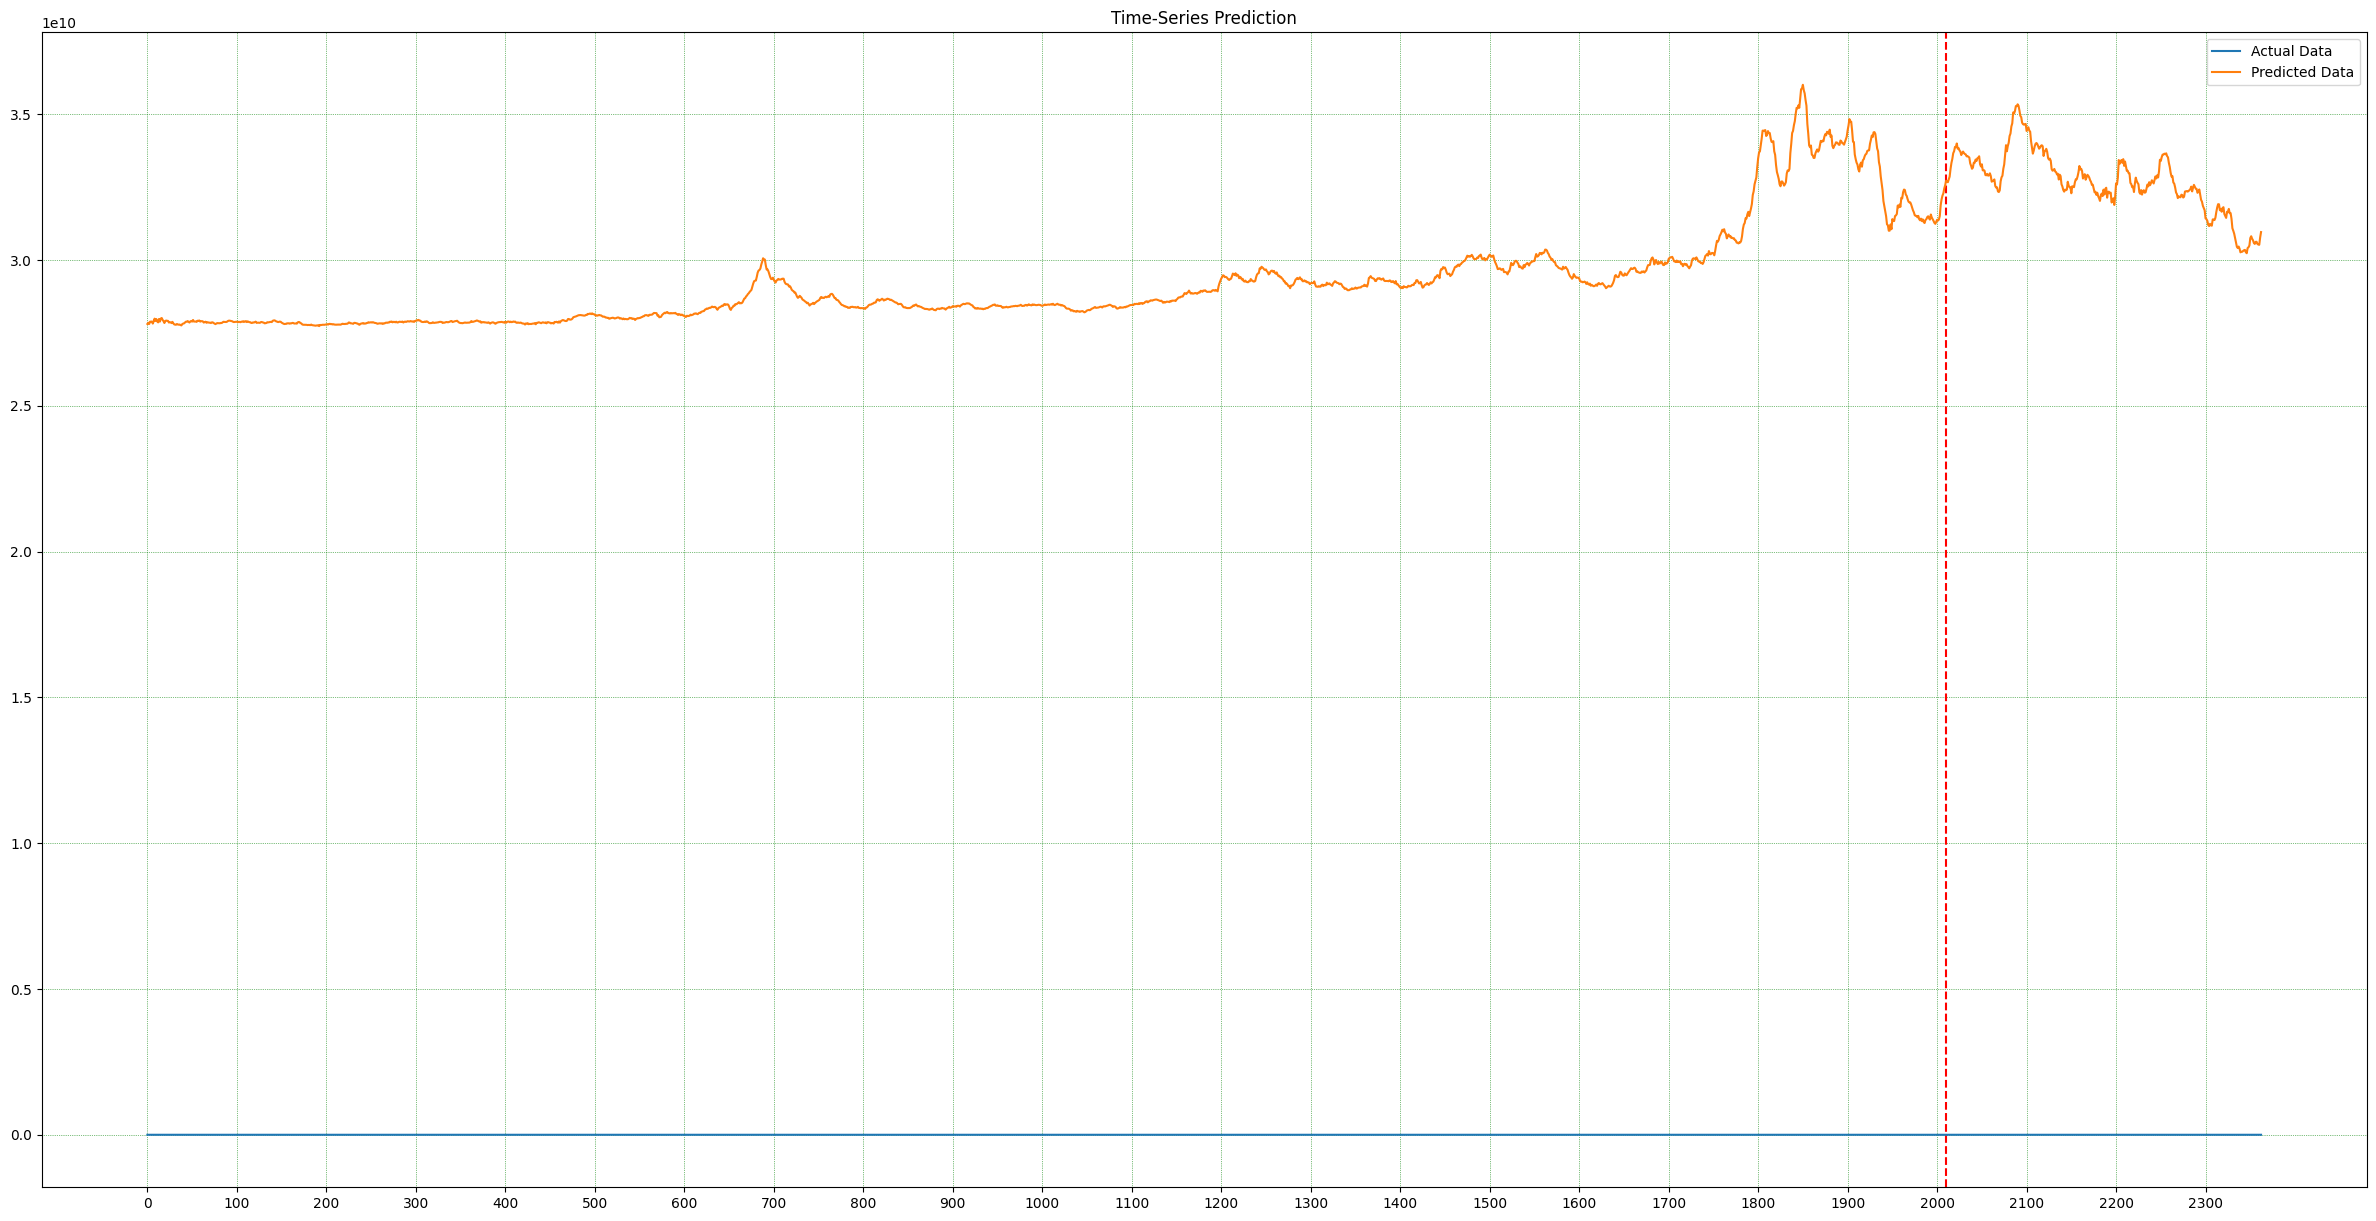

In [52]:
checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])

 
df_X_ss = SScaler.transform(pd.DataFrame(np.array(Y).reshape(-1, 1))) # old transformers
# df_C_ss = condscaler.transform(condtemp[["utxo_spent_value_median", "receiving_count","active_count", "volume_median",
#                                             "difficulty_latest", "SI=F", "^DJI", "^IXIC", "N225", "AVAX-USD", "BNB-USD",
#                                             "DOGE-USD", "LTC-USD", "SHIB-USD", "SOL-USD", "USDC-USD"]])
df_C_ss = condscaler.transform(condtemp)#[f_col])

# for i in range(0,len(selectmx.T)):
#   col2 = df_C_ss[:,i].copy()
#   col2 *= selectmx.T["price_usd_close"][i]/max(selectmx.T["price_usd_close"])-2
#   df_C_ss[:, i] = col2

# c_trans = pd.DataFrame(c_trans)
# c_trans = c_trans.drop(c_trans.columns[c_trans.apply(lambda col: col.all() == 0)], axis=1)

df_y_mm = MMScaler.transform(pd.DataFrame(np.array(Y).reshape(-1, 1)))
df_y_mm = df_y_mm.squeeze()
# split the sequence
df_X_ss, df_C_ss, df_y_mm = split_sequences(df_X_ss, df_C_ss, df_y_mm, x_shape, y_shape)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_C_ss = Variable(torch.Tensor(df_C_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], x_shape, df_X_ss.shape[2]))
df_C_ss = torch.reshape(df_C_ss, (df_C_ss.shape[0], x_shape, df_C_ss.shape[2]))

train_predict = myModel(df_X_ss.to(device),df_C_ss.to(device)).cpu() # forward pass

data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = MMScaler.inverse_transform(data_predict) # reverse transformation
dataY_plot = dataY_plot.squeeze()
dataY_plot = MMScaler.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])


plt.figure(figsize=(30,15)) #plotting
plt.axvline(x=train_test_cutoff -(x_shape), c='r', linestyle='--') # size of the training set

plt.xticks(range(0,total_samples,100))
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
# plt.savefig("whole_plot.png", dpi=300)
plt.show()

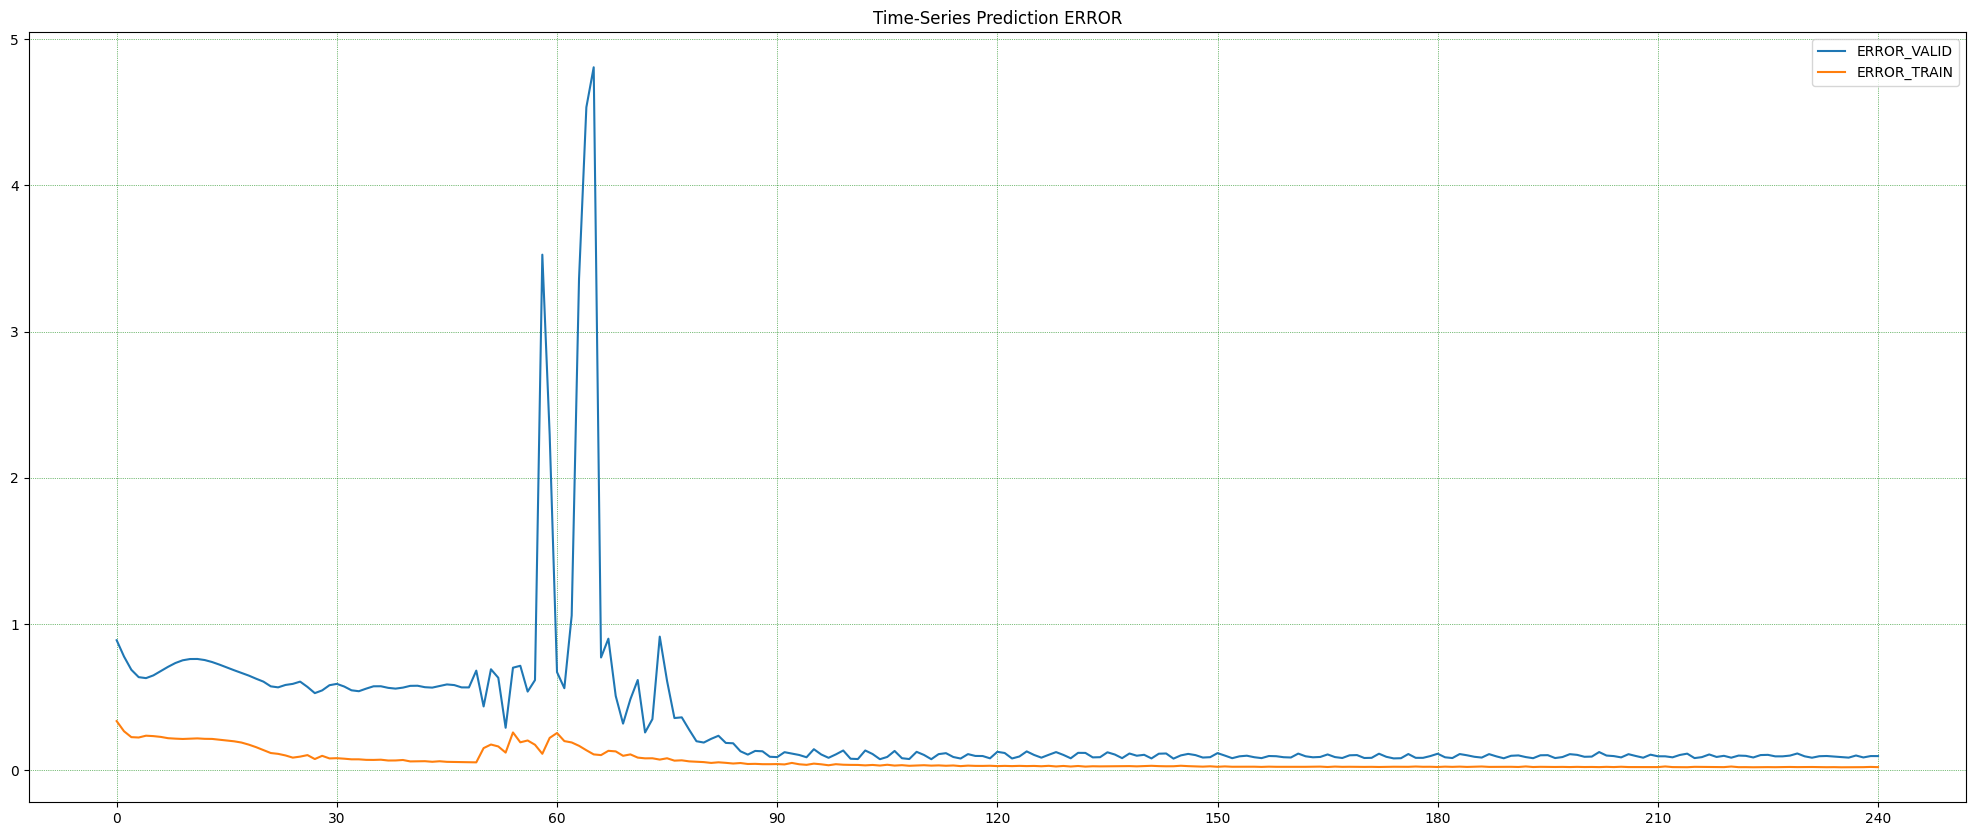

In [ ]:
plt.figure(figsize=(25,10)) #plotting
plt.plot(loss_valid_show, label='ERROR_VALID') 
plt.plot(loss_train_show, label='ERROR_TRAIN') 
plt.title('Time-Series Prediction ERROR')
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.xticks(range(0,n_epochs+1,30))
plt.legend()
plt.show()
# print(loss_show)


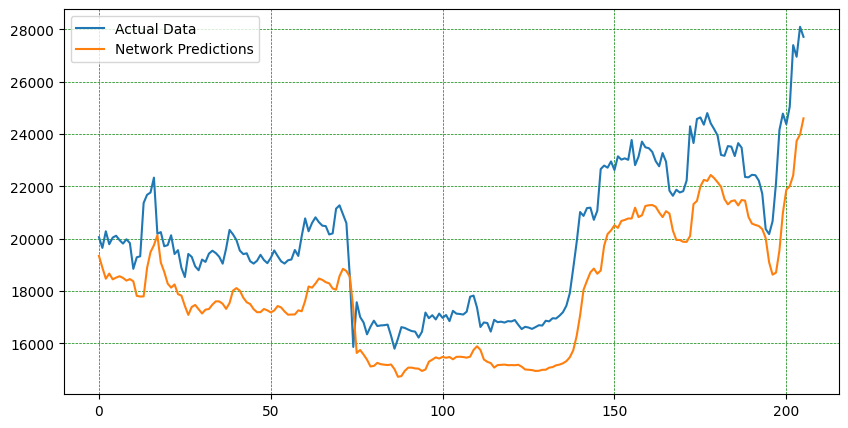

In [ ]:
plt.figure(figsize=(10,5)) #plotting
test_predict = myModel(DataX_test, DataC_test)  # get the last sample
test_predict = test_predict.detach().cpu().numpy()
test_predict = MMScaler_test.inverse_transform(test_predict)
first_day_test_predict = test_predict[:, 0]  # get the first day of the 7-day predictions

test_target = Datay_test.detach().cpu().numpy()  # last sample again
test_target = MMScaler_test.inverse_transform(test_target.flatten().reshape(1, -1))
first_day_test_target = test_target[:, ::7]  # get the corresponding first day in true price

plt.grid(color='g', linestyle='--', linewidth=0.5)
plt.plot(first_day_test_target[0], label="Actual Data")
plt.plot(first_day_test_predict, label="Network Predictions")
plt.legend()
plt.show()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs

# %load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/logs

In [ ]:
# !pip install pytorch-model-summary 
# import pytorch_model_summary as pms
# pms.summary(myModel, torch.zeros(X.shape[0], 30, X.shape[1]).to(device),torch.zeros(X.shape[0], 30, X.shape[1]).to(device), show_input=True, print_summary=True)

In [ ]:
checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])
# DataX_test, DataC_test, Datay_test

predict = myModel(DataX_test, DataC_test)
predict = predict.detach().cpu().numpy()
predict = MMScaler_test.inverse_transform(predict)
# predict = predict[-100:]
true = np.squeeze(Datay_test)
true = MMScaler_test.inverse_transform(true.cpu())
# true = true[-100:]

# calculate the daily returns based on the predicted and true prices
predict_returns = (predict[:, 1:] - predict[:, :-1]) / predict[:, :-1]
true_returns = (true[:, 1:] - true[:, :-1]) / true[:, :-1]

# calculate the position you would have taken based on your prediction
threshold = 0.00001  # 1% return threshold
predict_position = np.where(predict_returns > threshold, 1, -1)
true_position = np.where(true_returns > threshold, 1, -1)

# define a function to simulate the portfolio based on the predicted or true returns
def simulate_portfolio(position, returns, initial_capital):
    # calculate the daily profit and loss based on the position you took and the daily returns
    transaction_cost = 0.001  # 0.1% per transaction
    position_percentage = 0.2  # 10% of capital
    pnl = position * (initial_capital * position_percentage) * (returns - transaction_cost)

    # calculate the cumulative PnL over the entire period
    cumulative_pnl = np.cumsum(pnl)

    # calculate the final portfolio value
    final_value = initial_capital + cumulative_pnl[-1]

    # calculate the profit percentage
    profit_percentage = ((final_value - initial_capital) / initial_capital) * 100

    return final_value, profit_percentage

# simulate the portfolio based on the predicted and true returns for different initial capital values
for cap in [1000, 2000, 5000, 10000]:
    print(f"\nFor initial capital of {cap}:")
    predict_final_value, predict_profit_percentage = simulate_portfolio(predict_position, predict_returns, cap)
    true_final_value, true_profit_percentage = simulate_portfolio(true_position, true_returns, cap)
    print(f"Predicted final value   : {predict_final_value:.2f} with {predict_profit_percentage:.2f}% profit")
    print(f"True final value        : {true_final_value:.2f} with {true_profit_percentage:.2f}% profit")
    print(f"(Predicted/True)% profit: {predict_final_value*100/true_final_value:.2f}% profit") 
    print("-----------------------------------------------------------")


For initial capital of 1000:
Predicted final value   : 1097.61 with 9.76% profit
True final value        : 3349.44 with 234.94% profit
(Predicted/True)% profit: 32.77% profit
-----------------------------------------------------------

For initial capital of 2000:
Predicted final value   : 2195.21 with 9.76% profit
True final value        : 6698.87 with 234.94% profit
(Predicted/True)% profit: 32.77% profit
-----------------------------------------------------------

For initial capital of 5000:
Predicted final value   : 5488.03 with 9.76% profit
True final value        : 16747.18 with 234.94% profit
(Predicted/True)% profit: 32.77% profit
-----------------------------------------------------------

For initial capital of 10000:
Predicted final value   : 10976.05 with 9.76% profit
True final value        : 33494.36 with 234.94% profit
(Predicted/True)% profit: 32.77% profit
-----------------------------------------------------------


In [ ]:
# from sklearn.model_selection import ParameterGrid

# # Define the hyperparameter grid
# param_grid = {
#     'kernel_size_EN': [2,3],
#     'kernel_size_DE': [2,3],
#     'hidden_size_lstm': [20],
#     'num_levels_en': [2,4,6],
#     'num_levels_de': [2,4,6],
#     'num_layers_lstm': [6],
#     'num_layers_gru': [4]
# }
# loss_fn = NRMSELoss
# lr_decay_epoch = 49
# learning_rate = 0.01
# weight_decay = 0.001

# def run_experiment(params):
#     myModel = TSASeriesNet.ANNmodel(X_train_tensors_final.shape[1], C_train_tensors_final.shape[2], X_train_tensors_final.shape[2],y_train_tensors.shape[1],
#                                     params['num_levels_en'], params['num_levels_de'], params['kernel_size_EN'],
#                                     params['kernel_size_DE'], 2, params['hidden_size_lstm'],
#                                     params['num_layers_lstm'], params['num_layers_gru']).to(device)

#     optimiser = torch.optim.Adam(myModel.parameters(),weight_decay=0.0001)#, weight_decay=weight_decay, lr=learning_rate)

#     loss_train_show, loss_valid_show = training_loop(n_epochs=401,
#                                                       learning_rate=learning_rate,
#                                                       lr_decay_epoch=lr_decay_epoch,
#                                                       network=myModel,
#                                                       optimiser=optimiser,
#                                                       loss_fn= loss_fn,
#                                                       X_train=X_train_tensors_final,
#                                                       Condition_train=C_train_tensors_final,
#                                                       y_train=y_train_tensors,
#                                                       X_test=X_test_tensors_final,
#                                                       Condition_test=C_test_tensors_final,
#                                                       y_test=y_test_tensors)
#     return loss_valid_show[-1]

# import itertools

# def grid_search(param_grid):
#     keys, values = zip(*param_grid.items())
#     min_loss = float('inf')
#     best_params = None

#     for v in itertools.product(*values):
#         params = dict(zip(keys, v))
#         print(f"Running experiment with parameters: {params}")
#         loss = run_experiment(params)
#         print(f"Validation loss: {loss}")

#         if loss < min_loss:
#             min_loss = loss
#             best_params = params

#     return best_params, min_loss

# best_params, min_loss = grid_search(param_grid)
# print(f"Best parameters: {best_params}")
# print(f"Minimum validation loss: {min_loss}")


In [ ]:
import backtrader as bt
import pandas as pd

checkpoint = torch.load(f'./weights/model_epoch_{best_epoch}.pth')
myModel.load_state_dict(checkpoint['state_dict'])
# DataX_test, DataC_test, Datay_test

predict = myModel(DataX_test, DataC_test)
predict = predict.detach().cpu().numpy()
predict = pd.DataFrame(MMScaler_test.inverse_transform(predict))
predict.index = data.index[-106:]
predict = predict.rename_axis("datetime")

# predict = predict[-100:]
true = np.squeeze(Datay_test)
true = pd.DataFrame(MMScaler_test.inverse_transform(true.cpu()))
true.index = data.index[-106:]
true = true.rename_axis("datetime")

# Load the predicted data
predicted_data = pd.DataFrame(predict[0])
predicted_data = predicted_data.rename(columns={0: 'predicted'})
# predicted_data.index = data.index[-143:]
# Load the true data
true_data = pd.DataFrame(true[0])
true_data = true_data.rename(columns={0: 'true'})
# true_data.index = data.index[-143:]
# Define the strategy
class NeuralNetStrategy(bt.Strategy):
    params = (
        ('threshold', 0.05),
    )

    def __init__(self):
        self.data_predicted = self.datas[0]
        self.data_true = self.datas[1]

    def next(self):
        if self.data_predicted.close[0] > self.data_true.close[0] * (1 + self.params.threshold):
            self.buy()
        elif self.data_predicted.close[0] < self.data_true.close[0] * (1 - self.params.threshold):
            self.sell()

# Create a cerebro instance
cerebro = bt.Cerebro()

# Add the predicted data
predicted_data_feed = bt.feeds.PandasData(dataname=predicted_data)
cerebro.adddata(predicted_data_feed, name='predicted')

# Add the true data
true_data_feed = bt.feeds.PandasData(dataname=true_data)
cerebro.adddata(true_data_feed, name='true')

# Add the strategy
cerebro.addstrategy(NeuralNetStrategy, threshold=0.05)

# Set the cash and commission
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)

# Run the backtest
cerebro.run()

# Print the final portfolio value
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())